# In this Notebook we are attempting to predict if a person will win their next fight depending on how they performed on their last 5 fights

## Library Imports

In [7]:
import sys
sys.path.insert(1, '../combined_data')
sys.path.insert(1, '../predict_winner')
from make_career import make_career
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import talos as ta
from talos.model.normalizers import lr_normalizer
from talos.model.hidden_layers import hidden_layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import matplotlib.pyplot as plt
score_cols = ['precision', 'recall', 'fbeta_score', 'support']

## Loading the dataset

In [8]:
features, labels = make_career(N_FIGHT_CAREER=5)
labels = labels.reshape(-1,)

Creating careers using 5 fight intervals and predicting 1 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)

Features shape: (3220, 5)
Labels shape: (3220, 1)

Features is a 2D matrix with 3220 rows
Each row contains has 5 fights, and each fight has 100 keys

Labels is a 2D matrix with 3220 rows
Each row contains the the prediction for the next 1 fight(s)


In [9]:
print(features.shape)
print(type(features))

(3220, 5)
<class 'numpy.ndarray'>


In [10]:
print(labels.shape)
print(type(labels))

(3220,)
<class 'numpy.ndarray'>


## Preprocess Features

## Generates np.array of shape (3220, 5 * features)

In [11]:
from sklearn.utils import shuffle

def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.90)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
    print("X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

### Generates np.array of shape (3220, 5, win?)

## Building a DNN to predict the winner using last n fights

In [12]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)


In [13]:
# Define hyperparameters to use in Grid Search
dnn_params = {'lr': [0.01, 1, 2],
     'first_neuron': [128, 256],
     'hidden_layers': [1, 2],
     'batch_size': [64, 128, 256],
     'epochs': [10, 25],
     'dropout': [0.01, 0.1],
     'optimizer': [Adam],
     'shapes':['funnel'],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}

In [14]:
# Create the Neural Network
dnn_model = ta.Scan(x=X_train,
               y=y_train,
               model=get_dnn,
               params=dnn_params,
               experiment_name="UFC_5_Fight_Predictor")

100%|██████████| 144/144 [05:51<00:00,  2.44s/it]


In [15]:
results_df = dnn_model.data
print(results_df.shape, len(dnn_scores))
dnn_cols = list(results_df.columns)

new_df_data = []

for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in dnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = dnn_scores[index][score_index]
        
    new_df_data.append(new_row)

dnn_df = pd.DataFrame(new_df_data)

(144, 16) 144


In [16]:
dnn_df.drop(columns=['activation', 'last_activation', 'optimizer', 'support', 'losses'], inplace=True)
top_5_val_dnn = dnn_df.sort_values(by=['val_accuracy'], ascending=False).head(5)
top_5_acc_dnn = dnn_df.sort_values(by=['accuracy'], ascending=False).head(5)
top_5_val_dnn.to_csv('../model_results/UFC_Predict_5_Fights_DNN.csv')

In [17]:
top_5_val_dnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,first_neuron,hidden_layers,lr,shapes,precision,recall,fbeta_score
25,10,0.702965,0.601149,0.661139,0.609961,64,0.1,10,128,1,1.00,funnel,0.609296,0.930902,0.736522
43,25,0.750410,0.600000,0.619072,0.643491,64,0.1,25,256,1,1.00,funnel,0.608805,0.928983,0.735562
81,10,0.685888,0.600000,0.693467,0.567061,128,0.1,10,256,2,0.01,funnel,0.600698,0.990403,0.747826
130,10,0.706382,0.600000,0.660053,0.628698,256,0.1,10,256,2,1.00,funnel,0.621318,0.850288,0.717990
26,10,0.685606,0.598851,0.671229,0.569527,64,0.1,10,128,1,2.00,funnel,0.598851,1.000000,0.749101


## Building a CNN to predict the winner using last n fights

In [18]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


In [19]:
# Define hyperparameters to use in Grid Search
cnn_params = {'lr': [0.01, 0.1, 1],
     'num_filters': [64, 128],
     'kernel_size': [2],
     'batch_size': [64, 128],
     'epochs': [5, 15],
     'dropout': [0.01],
     'flatten_layer': [100, 150], 
     'optimizer': [Adam],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}

In [20]:
# Create the Neural Network
cnn_model = ta.Scan(x=X_train,
                y=y_train,
                model=get_cnn,
                params=cnn_params,
                experiment_name="UFC_5_Fight_Predictor_CNN")

100%|██████████| 48/48 [01:31<00:00,  1.90s/it]


In [21]:
results_df = cnn_model.data
cnn_cols = list(results_df.columns)
print(results_df.shape, len(cnn_scores))

new_df_data = []

for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in cnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = cnn_scores[index][score_index]
        
    new_df_data.append(new_row)

cnn_df = pd.DataFrame(new_df_data)

(48, 16) 48


In [22]:
cnn_df.drop(columns=['activation', 'last_activation', 'optimizer', 'support', 'losses'], inplace=True)
top_5_val_cnn = cnn_df.sort_values(by=['val_accuracy'], ascending=False).head(5)
top_5_acc_cnn = cnn_df.sort_values(by=['accuracy'], ascending=False).head(5)
top_5_val_cnn.to_csv('../model_results/UFC_Predict_5_Fights_CNN.csv')

In [23]:
top_5_val_cnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,flatten_layer,kernel_size,lr,num_filters,precision,recall,fbeta_score
13,15,0.679476,0.594253,0.663785,0.601085,64,0.01,15,100,2,0.01,128,0.604749,0.860835,0.710418
39,15,0.683834,0.590805,0.569896,0.736193,128,0.01,15,100,2,0.10,128,0.610860,0.805169,0.694683
44,15,0.685555,0.585057,0.612971,0.683925,128,0.01,15,150,2,0.10,64,0.611987,0.771372,0.682498
33,5,0.684932,0.580460,0.647354,0.618343,128,0.01,5,150,2,0.10,128,0.592992,0.874751,0.706827
38,15,0.685033,0.579310,0.618025,0.665187,128,0.01,15,100,2,0.10,64,0.607535,0.769384,0.678947


## Building an LSTM to predict the winner using last n fights

In [24]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


Train on 2898 samples, validate on 322 samples
Epoch 1/30
2898/2898 [==============================] - 1s 196us/step - loss: 0.6984 - accuracy: 0.5476 - val_loss: 0.6901 - val_accuracy: 0.5590
Epoch 2/30
2898/2898 [==============================] - 0s 56us/step - loss: 0.6496 - accuracy: 0.6225 - val_loss: 0.6914 - val_accuracy: 0.5621
Epoch 3/30
2898/2898 [==============================] - 0s 70us/step - loss: 0.6262 - accuracy: 0.6549 - val_loss: 0.7242 - val_accuracy: 0.5342
Epoch 4/30
2898/2898 [==============================] - 0s 72us/step - loss: 0.5878 - accuracy: 0.6874 - val_loss: 0.7130 - val_accuracy: 0.5497
Epoch 5/30
2898/2898 [==============================] - 0s 72us/step - loss: 0.5398 - accuracy: 0.7253 - val_loss: 0.7455 - val_accuracy: 0.5466
Epoch 6/30
2898/2898 [==============================] - 0s 73us/step - loss: 0.4834 - accuracy: 0.7685 - val_loss: 0.8236 - val_accuracy: 0.5093
Epoch 7/30
2898/2898 [==============================] - 0s 75us/step - loss: 0.431

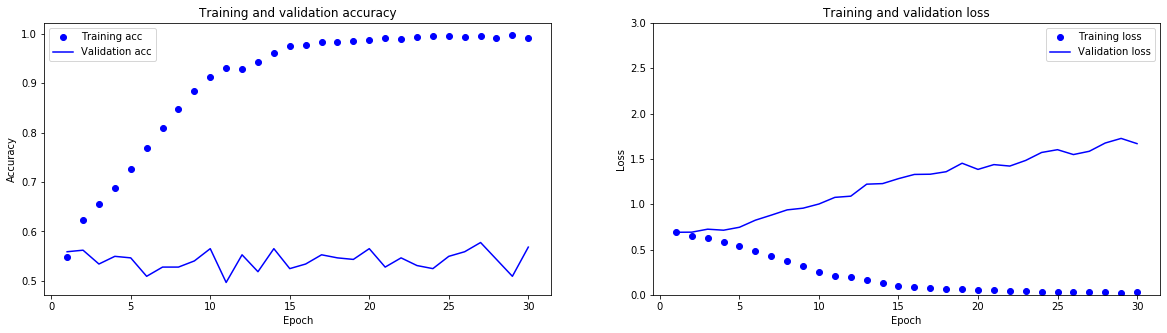

In [25]:
history, model = get_lstm(X_train, y_train, X_test, y_test, test_model=True)

In [26]:
hist = history.history
lstm_data = [hist['accuracy'][-1], hist['val_accuracy'][-1], hist['loss'][-1], hist['val_loss'][-1]]
lstm_data = lstm_data + [lstm_scores[0][0], lstm_scores[0][1], lstm_scores[0][2], lstm_scores[0][3]]
lstm_cols = ['accuracy', 'val_accuracy', 'loss', 'val_loss'] + score_cols


lstm_df = pd.DataFrame(data=[lstm_data], columns=lstm_cols)
lstm_df.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
lstm_df

,accuracy,val_accuracy,loss,val_loss,precision,recall,fbeta_score,support
0,0.992063,0.568323,0.031037,1.668706,0.657609,0.614213,0.635171,None


In [27]:
lstm_df.to_csv('../model_results/UFC_Predict_5_Fights_LSTM.csv')

# Model Builders

In [28]:
# Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid

### Analyzing last n fights using an LSTM

In [29]:
lstm_scores = []

def get_lstm(x_train, y_train, x_val, y_val, test_model=False):
    model = Sequential()
    
    model.add(LSTM(50, 
                   input_shape=(5, 97),
                   recurrent_dropout=0.2)) #, return_sequences=True
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", 
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=64,
                       epochs=30,
                       verbose=1)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    lstm_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

### Analyzing last n fights using a Dense Neural Network

In [30]:
dnn_scores = []

def get_dnn(x_train, y_train, x_val, y_val, params, test_model=False):
    
    model = Sequential()
    # Input Layer
    model.add(Dense(params["first_neuron"], 
                    activation=params['activation'], 
                    input_dim=X_train.shape[1]))
    
    model.add(Dropout(params['dropout']))
    
    # Hidden Layers
    hidden_layers(model, params, 1)
    
    # Output Layers
    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
                  
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    dnn_scores.append(score)
    
    if test_model:
        model.summary()
        plot_training_results(history)
        

    return history, model

### Analyzing last n fights using a Convolutional Neural Network

In [31]:
cnn_scores = []

def get_cnn(x_train, y_train, x_val, y_val, params, test_model=False):
    model = Sequential()
    
    # Convolutional Layers
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu', input_shape=(5, 97)))
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu'))
    model.add(Dropout(params['dropout']))
#     model.add(MaxPooling1D(pool_size=2))
    
    # Flatten Layers
    model.add(Flatten())
    model.add(Dense(params["flatten_layer"], activation='relu'))
#     model.add(Dense(params["flatten_layer"], activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    cnn_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

## Helper Functions

In [32]:
def plot_training_results(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, (accuracy_axis, loss_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc, 'bo', label='Training acc')
    accuracy_axis.plot(epochs, val_acc, 'b', label='Validation acc')
    accuracy_axis.set_title('Training and validation accuracy')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()

    loss_axis.plot(epochs, loss, 'bo', label='Training loss')
    loss_axis.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_axis.set_title('Training and validation loss')
    loss_axis.set_ylim(0, 3)
    loss_axis.set_ylabel('Loss')
    loss_axis.set_xlabel('Epoch')
    loss_axis.legend()
    fig.show()

## Extract numerical and categorical columns

In [33]:
# Get the first fight window and the first fight in that window
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols

In [34]:
x, y = get_column_types()